<img style="float: left;" src="icon.jpg">
<img style="float: right;" src="https://www.tudublin.ie/media/website/site-assets/images/tu-dublin-logo-blue.svg">

<br><br><br><br>

# Eye of Another World :: Weapon Visualizer


by  <a href="mailto:X00193937@mytudublin.ie">Jorge Jimenez Garcia</a> 


## Sections:
* <a href="#dep_and_prereq"> Dependencies, Imports, Prerequisites and Global Configs </a>
* <a href="#prelude">Prelude </a>
* <a href="#visualization"> Visualization </a>
    * <a href="#usage stats"> Usage Statistics </a>
    * <a href="#density"> Density plots </a>

<a name="dep_and_prereq"> </a>
## Dependencies, Imports, Prerequisites and Global Configs

In [1]:

# IMPORTS-------------------------
import sqlite3
from collections import Counter
import ctypes
import pickle
import json
import zipfile
import requests
import os
from io import BytesIO
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# CONSTANTS-----------------------------
BNET_URL = 'http://Bungie.net'
MANIFEST_SUFFIX = '/Platform/Destiny2/Manifest/'
WEAPON_SLOT_NAMES = ['', 'Primary', 'Special', 'Power']

PROPERTIES_QUERY = """
SELECT json_extract(json, '$.displayProperties.name'), json_extract(json, '$.inventory.tierTypeName'), json_extract(json, '$.itemTypeDisplayName'), json_extract(json, '$.equippingBlock.ammoType'), json_extract(json, '$.sockets.socketEntries'), json_extract(json, '$.stats.stats')
FROM DestinyInventoryItemDefinition WHERE id == {}
"""
FRAME_NAME_QUERY = """
SELECT json_extract(json, '$.displayProperties.name')
FROM DestinyInventoryItemDefinition WHERE id == {}
"""

HASH_STABILITY = str(155624089)
HASH_HANDLING = str(943549884)
HASH_RANGE = str(1240592695)
HASH_AIMASSIST = str(1345609583)
HASH_AIRBORNEEFF = str(2714457168)
HASH_RECOILDIR = str(2715839340)
HASH_ZOOM = str(3555269338)
HASH_MAGSIZE = str(3871231066)
HASH_IMPACT = str(4043523819)
HASH_RELOAD = str(4188031367)
HASH_RPM = str(4284893193)

##----SPECIFIC STATS TO CLASS--------

HASH_FR_CHARGETIME = str(2961396640)

##bows have chargetime? id == to fusion chargetime, but the stat is always 0?
HASH_BOW_DRAWTIME = str(447667954) # ~rpm?
HASH_BOW_ACCURACY = str(1591432999)

HASH_RLGL_VELOCITY = str(2523465841)
HASH_RLGL_BLASTRADIUS = str(3614673599)

HASH_GLAIVE_SHIELDDUR = str(1842278586)

HASH_SWORD_GUARDRES = str(209426660)
HASH_SWORD_GUARDEFF = str(2762071195)
HASH_SWORD_SWINGSPEED = str(2837207746) # ~rpm?
HASH_SWORD_CHARGERATE = str(3022301683)


_Config settings:_


#### `CONFIG__DF_IGNORE_EXOTICS`: Why leave out Exotic weapons?

Exotic weapons are the stand out in a players arsenal. Unique in their behaviour, they would be useless data in our study, since they have traits generally exclusive to them, and so including them in our pool of analyzed traits does not help us predict the popularity of gear, because no other item will have those traits

#### `CONFIG__DATA_FILE_NAME`:

File name to load and process as a dataFrame

In [2]:
# CONFIG----------------------------
CONFIG__DF_IGNORE_EXOTICS = True
CONFIG__DATA_FILE_NAME = 'RAD2MODE70-from2022-09-23-to2022-10-03'

# Force reload of the dataframe
from IPython.display import Javascript
Javascript("Jupyter.notebook.execute_cells([6])")

<IPython.core.display.Javascript object>

<a name="prelude" > </a>
## Prelude

### Data Set construction

#### Chosen attributes

Across the several weapon categories, items have different sets of stats, to the point where some categories will have stats only found for that category. For the meantime, they are ketp in the dataset and filled out as NaN for items where the stat is not applicable or meaningless.


<br><br>



___NOTE___: __This preliminary dataset does not contain perk data__, perks are properties of weapons that alter their stats, behaviour, expand their functionality, or a combination of the above. __Perks are randomly selected for a pool of possible choices set for a weapon, and generally each weapon has two of them.__

In the API, these are represented as a list of the hashes of these possible perks. Since it is out of our scope to convey how each perk affects a weapon, __we would like to keep the possible set as a feature__, with the hypothesis that the possibility of certain perks appearing on a weapon is one of the key factors that boost their popularity. _However_, for the meantime, how we would represent this in the dataframe is unclear.

In [22]:

# Read data file
with open(CONFIG__DATA_FILE_NAME + '.d2data', 'rb') as f:
    (weaponFreq, gameSet) = pickle.load(f)
    print('Loaded dataSet: {} weapon instances ({} unique) across {} unique games.'.format(sum(weaponFreq.values()), len(weaponFreq.keys()), len(gameSet)))
    if CONFIG__DF_IGNORE_EXOTICS:
        print('[INFO]: Config::IgnoreExotics is set: Some instances will be ignored')

# Check Manifest, and update if needed
manifest_location = requests.get(BNET_URL + MANIFEST_SUFFIX).json()['Response']['mobileWorldContentPaths']['en']
DB_NAME = manifest_location[35:]
if not os.path.exists(DB_NAME):
    print('{} not found: Downloading Destiny Manifest, this may take a while...'.format(DB_NAME))
    manifest_zip = requests.get(BNET_URL + manifest_location).content
    print('Up-to-date Manifest downloaded:')
    with zipfile.ZipFile(BytesIO(manifest_zip)) as z:
        with open(DB_NAME, 'wb') as f:
            f.write(z.read(DB_NAME))


db = sqlite3.connect(DB_NAME).cursor()

name_l = []
weaponid = []
weapon_type = []
weapon_archetype = []
weapon_slot = []
usage_absolute = []
usage_rate = []
usage_rate_slot = []


# Stats
stability = []
handling = []
rang = []
aim_assist = []
airborne_effectiveness = []
recoil_direction = []
zoom = []
magsize = []
impact = []
reload = []
rpm = []

bow_drawtime = []
bow_accuracy = []
fr_chargetime = []
rlgl_velocity = []
rlgl_blastradius = []
glaive_shieldduration = []
sword_guardresistence = []
sword_guardefficiency = []
sword_swingspeed = []
sword_chargerate = []


stat_arr = [stability,handling,rang,aim_assist,airborne_effectiveness,recoil_direction,zoom,magsize,impact,reload,rpm,bow_drawtime,bow_accuracy,fr_chargetime,rlgl_velocity,rlgl_blastradius,glaive_shieldduration,sword_guardresistence,sword_guardefficiency,sword_swingspeed,sword_chargerate]
stat_hash_arr = [HASH_STABILITY,HASH_HANDLING,HASH_RANGE,HASH_AIMASSIST,HASH_AIRBORNEEFF,HASH_RECOILDIR,HASH_ZOOM,HASH_MAGSIZE,HASH_IMPACT,HASH_RELOAD,HASH_RPM,HASH_BOW_DRAWTIME,HASH_BOW_ACCURACY,HASH_FR_CHARGETIME,HASH_RLGL_VELOCITY,HASH_RLGL_BLASTRADIUS,HASH_GLAIVE_SHIELDDUR,HASH_SWORD_GUARDRES,HASH_SWORD_GUARDEFF,HASH_SWORD_SWINGSPEED,HASH_SWORD_CHARGERATE]


slot_totals = {'Primary': 0, 'Special': 0, 'Power': 0 }
for weaponId, ct in weaponFreq.items():
        name, tier, weaponType, weaponSlot, sockets, stats = db.execute(PROPERTIES_QUERY.format(ctypes.c_int32(weaponId).value)).fetchall()[0]

        weaponSlot = WEAPON_SLOT_NAMES[weaponSlot]
        sockets = json.loads(sockets) # Perks: TODO
        stats = json.loads(stats)
        
        if tier != 'Exotic':
            frameId = sockets[0]['singleInitialItemHash']
            frame = db.execute(FRAME_NAME_QUERY.format(ctypes.c_int32(frameId).value)).fetchall()[0][0]
            
            # Unify special frame names THAT DO NOT CHANGE BEHAVIOUR
            if frame == "Together Forever" or frame == "Omolon Adaptive Frame":
                frame = "Adaptive Frame"
            elif frame == "MIDA Synergy":
                frame = "Lightweight Frame"
            elif frame == "VEIST Rapid-Fire":
                frame = "Rapid-Fire Frame"
                
        else:
            if CONFIG__DF_IGNORE_EXOTICS:
                continue
            frame = 'Exotic'
            
        for idx, stat_hash in enumerate(stat_hash_arr):
            try:
                stat_arr[idx].append(stats[stat_hash]['value'])
            except KeyError:
                stat_arr[idx].append(None)
        
        # Update lists for df
        name_l.append(name)
        weaponid.append(weaponId)
        weapon_type.append(weaponType)
        weapon_archetype.append(frame)
        weapon_slot.append(weaponSlot)
        slot_totals[weaponSlot] += ct
        usage_absolute.append(ct)


total_count = sum(usage_absolute)
for i in range(len(weapon_slot)):
    slot = weapon_slot[i]
    uabs = usage_absolute[i]
    urat_slot = uabs / slot_totals[slot]
    urat = uabs / total_count
    
    usage_rate.append( urat * 100 )
    usage_rate_slot.append( urat_slot * 100)
    
print("Generating DataFrame: {} instances, of which {} are unique".format(total_count, len(usage_rate)))

df = pd.DataFrame(
    {
        'Name': pd.Series(name_l, dtype='category'),
        'Weapon Type': pd.Series(weapon_type, dtype='category'),
        'Archetype': pd.Series(weapon_archetype, dtype='category'),
        'Slot': pd.Series(weapon_slot, dtype='category'),
        'WeaponID': pd.Series(weaponid, dtype='category'),
        'Stability': stability,
        'Handling': handling,
        'Range': rang,
        'Aim Assistance': aim_assist,
        'Airborne Effectiveness': airborne_effectiveness,
        'Recoil Direction': recoil_direction,
        'Zoom': zoom,
        'Magazine Size': magsize,
        'Impact': impact,
        'Reload Speed': reload,
        'Rounds Per Minute': rpm,
        'Draw Time': bow_drawtime,
        'Accuracy': bow_accuracy,
        'Charge Time': fr_chargetime,
        'Velocity': rlgl_velocity,
        'Blast Radius': rlgl_blastradius,
        'Shield Duration': glaive_shieldduration,
        'Guard Resistance': sword_guardresistence,
        'Guard Efficiency': sword_guardefficiency,
        'Swing Speed': sword_swingspeed,
        'Charge Rate': sword_chargerate,
        'Ocurrences': usage_absolute,
        'Usage Rate in Slot (%)': usage_rate_slot,
        'Global Usage Rate (%)': usage_rate,
        
    }
)

df.to_csv(CONFIG__DATA_FILE_NAME + '.csv')
df.sort_values(by = 'Ocurrences', ascending=False, inplace=True)
df

Loaded dataSet: 21525 weapon instances (536 unique) across 813 unique games.
[INFO]: Config::IgnoreExotics is set: Some instances will be ignored
Generating DataFrame: 15000 instances, of which 442 are unique


,Name,Weapon Type,Archetype,Slot,WeaponID,Stability,Handling,Range,Aim Assistance,Airborne Effectiveness,...,Velocity,Blast Radius,Shield Duration,Guard Resistance,Guard Efficiency,Swing Speed,Charge Rate,Ocurrences,Usage Rate in Slot (%),Global Usage Rate (%)
3,Austringer,Hand Cannon,Adaptive Frame,Primary,3055790362,59.0,47.0,46.0,75.0,13.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,771,10.062647,5.140000
13,Wastelander M5,Shotgun,Lightweight Frame,Special,1679868061,40.0,66.0,44.0,49.0,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,643,11.225559,4.286667
36,BxR-55 Battler,Pulse Rifle,Legacy PR-55 Frame,Primary,2708806099,59.0,71.0,50.0,85.0,10.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,625,8.157139,4.166667
39,Out of Bounds,Submachine Gun,Lightweight Frame,Primary,2988121501,43.0,67.0,32.0,55.0,23.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,474,6.186374,3.160000
5,Without Remorse,Shotgun,Lightweight Frame,Special,1478986057,43.0,64.0,45.0,55.0,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,446,7.786313,2.973333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
355,Hoosegow,Rocket Launcher,Adaptive Frame,Power,3669616453,41.0,38.0,NaN,63.0,3.0,...,53.0,50.0,NaN,NaN,NaN,NaN,NaN,1,0.062112,0.006667
354,Halfdan-D,Auto Rifle,High-Impact Frame,Primary,1518042134,20.0,39.0,80.0,60.0,10.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0.013051,0.006667
350,Arctic Haze,Auto Rifle,Rapid-Fire Frame,Primary,20935540,48.0,42.0,24.0,75.0,10.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0.013051,0.006667
347,Exit Strategy,Submachine Gun,Adaptive Frame,Primary,4227181568,42.0,50.0,37.0,47.0,12.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0.013051,0.006667


<a name="visualization"> </a>
## Visualization

<a name="usage stats"> </a>
#### Usage statistics:

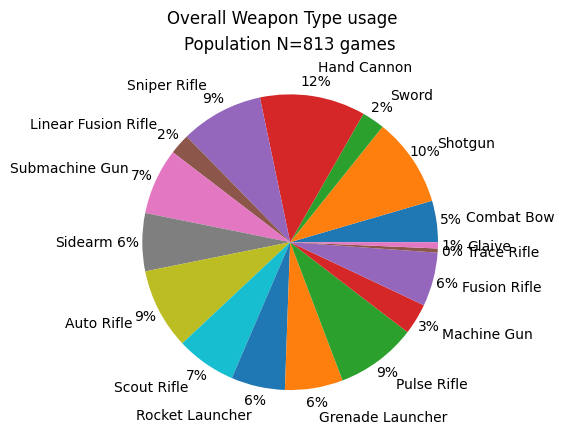

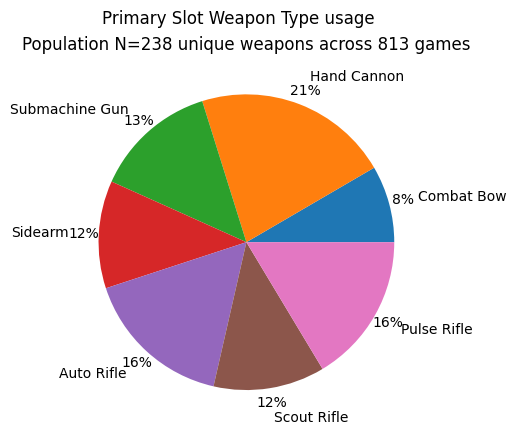

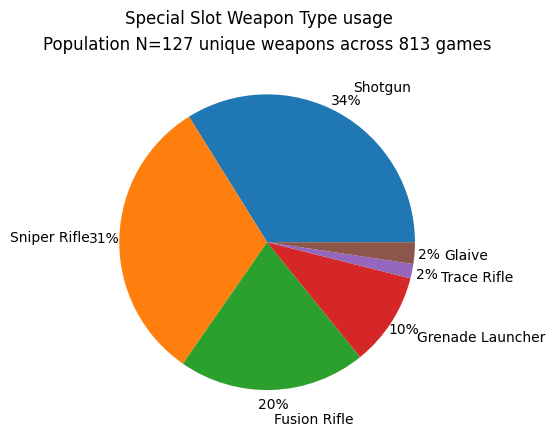

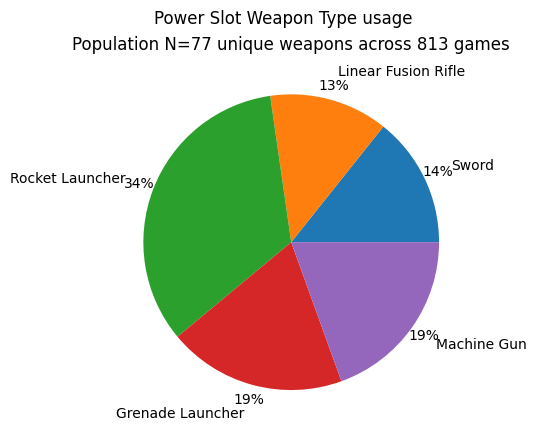

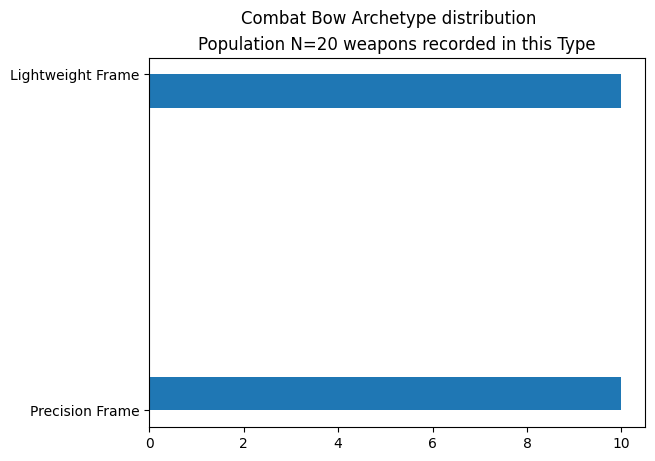

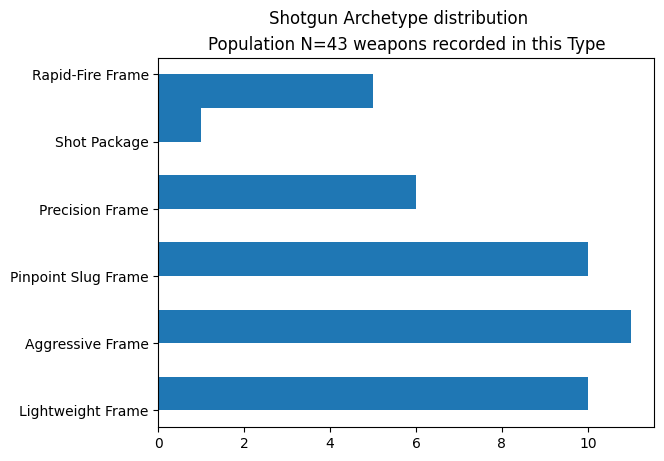

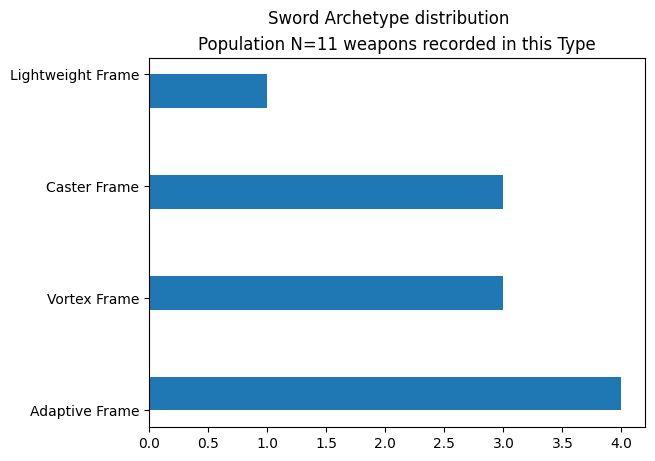

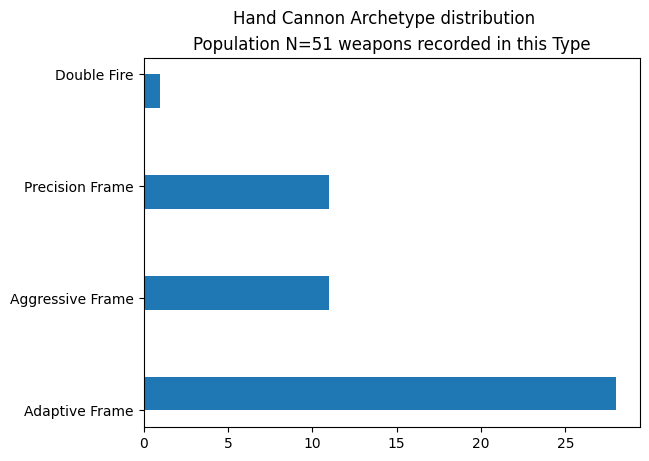

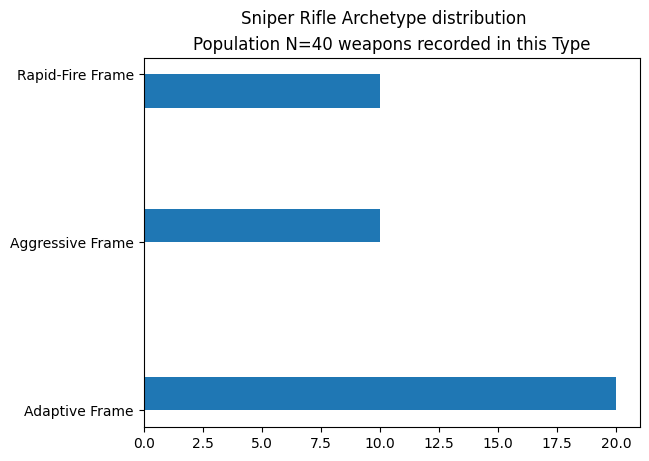

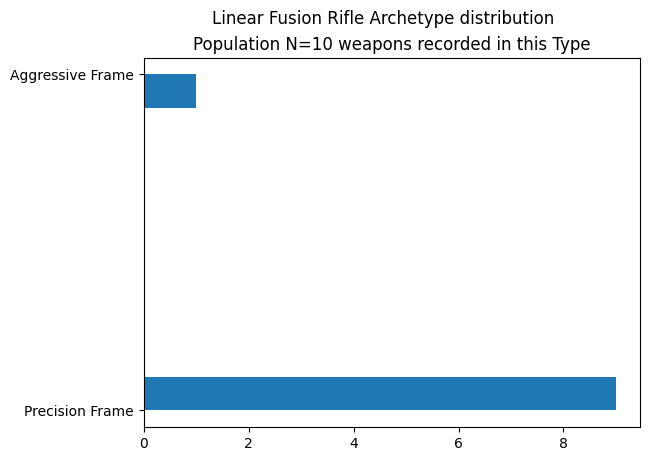

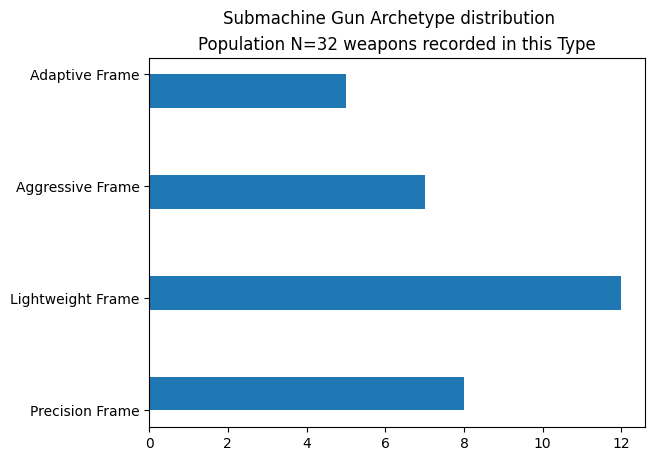

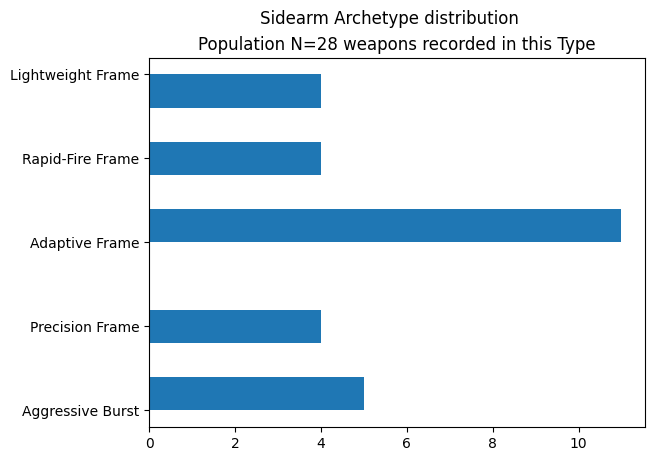

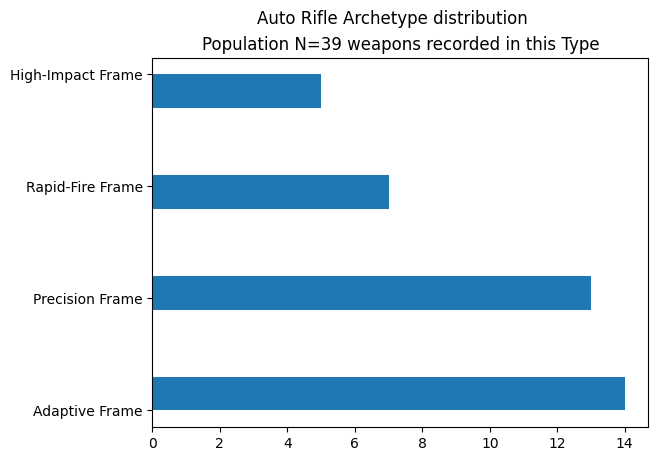

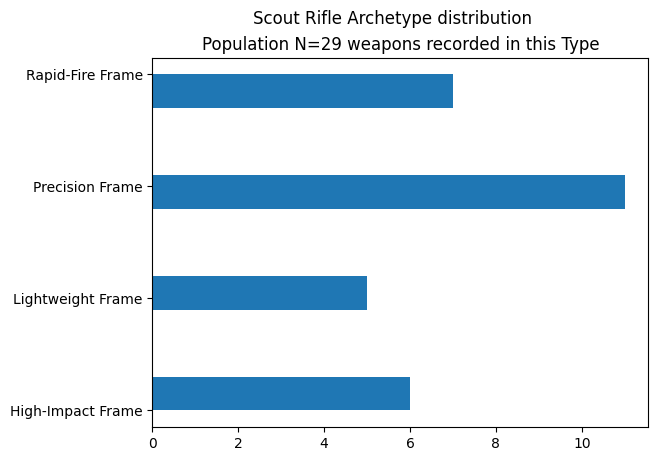

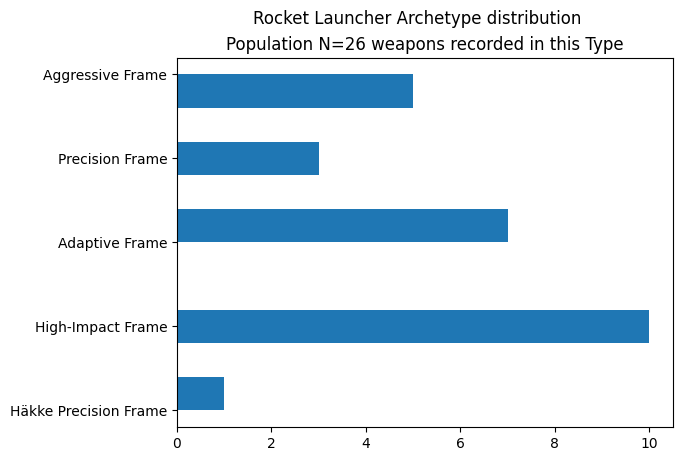

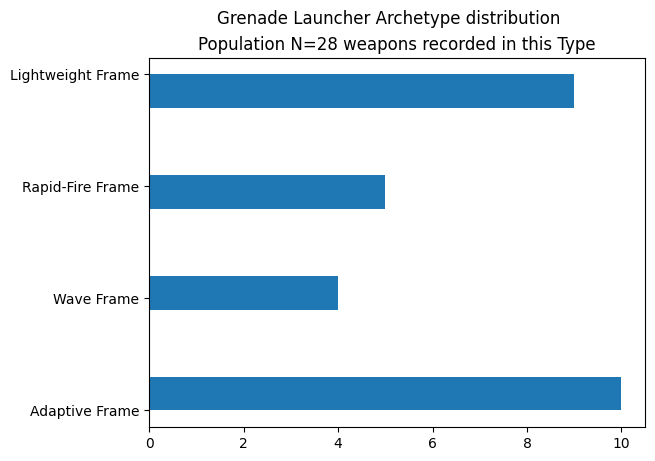

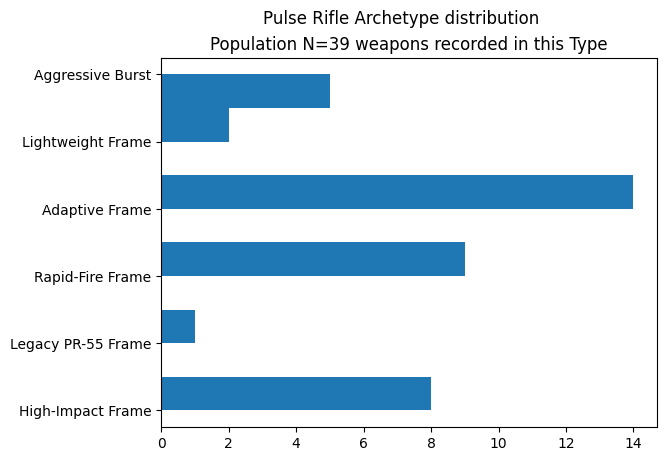

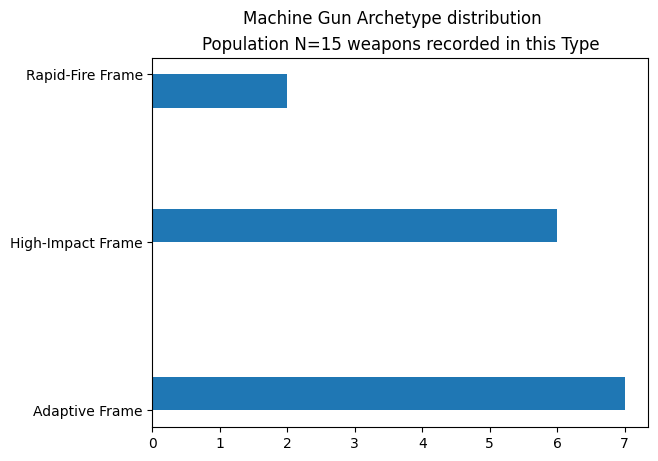

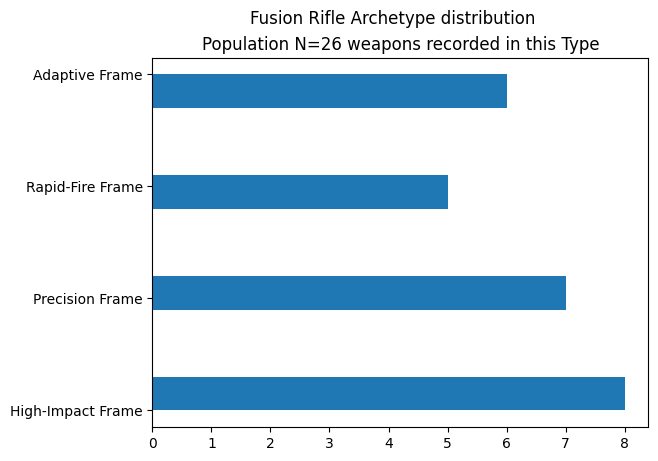

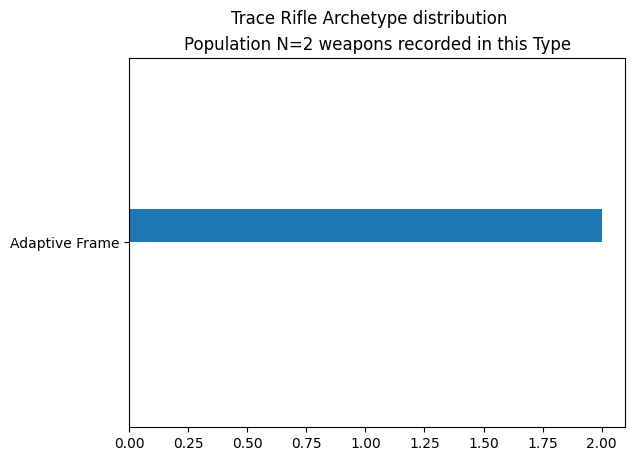

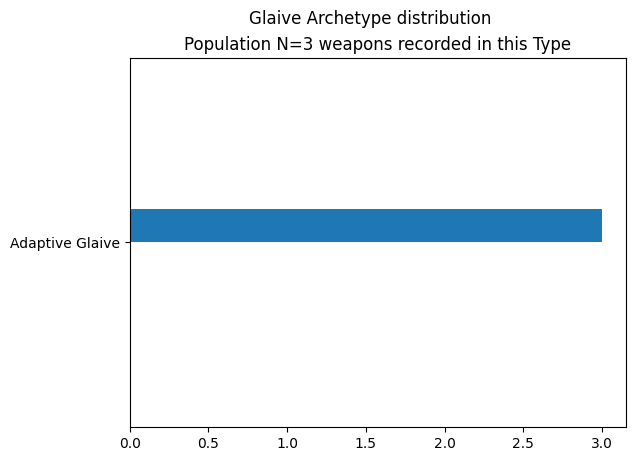

In [4]:

plt.suptitle('Overall Weapon Type usage')
plt.title('Population N={} games'.format(len(gameSet)))
weapon_type_counter = Counter(df['Weapon Type'])
plt.pie(weapon_type_counter.values(), labels=weapon_type_counter.keys(), autopct='%1.0f%%', pctdistance=1.1, labeldistance=1.2)
plt.show()


for slot in df['Slot'].unique():
    subset_by_slot = df.loc[df['Slot'] == slot]
    weapon_type_counter = Counter(subset_by_slot['Weapon Type'])
    plt.suptitle('{} Slot Weapon Type usage'.format(slot))
    plt.title('Population N={} unique weapons across {} games'.format(len(subset_by_slot), len(gameSet)))
    plt.pie(weapon_type_counter.values(), labels=weapon_type_counter.keys(), autopct='%1.0f%%', pctdistance=1.1, labeldistance=1.2)
    plt.show()

for weaponType in df['Weapon Type'].unique():
    subset_by_slot = df.loc[df['Weapon Type'] == weaponType]
    plt.suptitle('{} Archetype distribution'.format(weaponType))
    plt.title('Population N={} weapons recorded in this Type'.format(len(subset_by_slot)))
    plt.hist(subset_by_slot['Archetype'], orientation='horizontal')
    plt.show()
    


#### Stat distributions 

In [5]:
print('Stat Means:----------------------------\n')
print(df.mean(numeric_only=True))
print('\nStat Skews:--------------------------\n')
print(df.skew(numeric_only=True))
print('\nStat Standard Deviation--------------\n')
print(df.std(numeric_only=True))

Stat Means:----------------------------

Stability                  40.565217
Handling                   44.178654
Range                      45.146739
Aim Assistance             61.055684
Airborne Effectiveness      9.551471
Recoil Direction           72.091121
Zoom                       17.931663
Magazine Size              18.161137
Impact                     55.744845
Reload Speed               40.431555
Rounds Per Minute         282.472000
Draw Time                 632.400000
Accuracy                   49.850000
Charge Time               382.442857
Velocity                   52.250000
Blast Radius               62.407407
Shield Duration            42.333333
Guard Resistance            0.000000
Guard Efficiency            0.000000
Swing Speed                43.636364
Charge Rate                28.636364
Ocurrences                 33.936652
Usage Rate in Slot          0.006787
Global Usage Rate (%)       0.063315
dtype: float64

Stat Skews:--------------------------

Stability       